In [89]:
from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType)
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder,VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col,count,when,isnull
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [90]:
# Cargar el conjunto de datos completo
import findspark
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

hotels_df = spark \
    .read \
    .format("csv") \
    .option("path", "hotel_booking.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("hotel", StringType()),
                StructField("is_canceled", StringType()),
                StructField("lead_time", IntegerType()),
                StructField("arrival_date_year", StringType()),
                StructField("arrival_date_month", StringType()),
                StructField("arrival_date_week_number", IntegerType()),
                StructField("arrival_date_day_of_month", IntegerType()),
                StructField("stays_in_weekend_nights", IntegerType()),
                StructField("stays_in_week_nights", IntegerType()),
                StructField("adults", IntegerType()),
                StructField("children", FloatType()),
                StructField("babies", FloatType()),
                StructField("meal", StringType()),
                StructField("country", StringType()),
                StructField("market_segment", StringType()),
                StructField("distribution_channel", StringType()),
                StructField("is_repeated_guest", StringType()),
                StructField("previous_cancellations", IntegerType()),
                StructField("previous_bookings_not_canceled", IntegerType()),
                StructField("reserved_room_type", StringType()),
                StructField("assigned_room_type", StringType()),
                StructField("booking_changes", IntegerType()),
                StructField("deposit_type", StringType()),
                StructField("agent", FloatType()),
                StructField("company", FloatType()),
                StructField("days_in_waiting_list", IntegerType()),
                StructField("customer_type", StringType()),
                StructField("adr", FloatType()),
                StructField("required_car_parking_spaces", IntegerType()),
                StructField("total_of_special_requests", IntegerType()),
                StructField("reservation_status", StringType()),
                StructField("reservation_status_date", StringType()),
                StructField("name", StringType()),
                StructField("email", StringType()),
                StructField("phone-number", StringType()),
                StructField("credit_card", StringType())])) \
    .load()

hotels_df.printSchema()
hotels_df.show()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: string (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: string (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: float (nullable = true)
 |-- babies: float (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: string (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = t

In [91]:
# Se quita la informacion personal y fecha de reservacion del datset
hotels_columns_df = hotels_df.drop("reservation_status_date","name","email","phone-number","credit_card")

In [92]:
#Se muestra el resumen de cada variable en el dataset
hotels_columns_df.select(['hotel',"is_canceled",
              'lead_time','arrival_date_year','arrival_date_month','arrival_date_week_number'] ).summary().show()

hotels_columns_df.select(['arrival_date_day_of_month','stays_in_weekend_nights',
              'stays_in_week_nights','adults','children'] ).summary().show()

hotels_columns_df.select(['babies','meal',
              'country','market_segment','distribution_channel',"is_repeated_guest","previous_cancellations"] ).summary().show()

hotels_columns_df.select(['previous_bookings_not_canceled','reserved_room_type',
              'assigned_room_type','booking_changes','deposit_type'] ).summary().show()

hotels_columns_df.select(['days_in_waiting_list','customer_type',
              'adr','required_car_parking_spaces','total_of_special_requests'] ).summary().show()

hotels_columns_df.select(['reservation_status'] ).summary().show()

+-------+------------+-------------------+------------------+------------------+------------------+------------------------+
|summary|       hotel|        is_canceled|         lead_time| arrival_date_year|arrival_date_month|arrival_date_week_number|
+-------+------------+-------------------+------------------+------------------+------------------+------------------------+
|  count|      119390|             119390|            119390|            119390|            119390|                  119390|
|   mean|        null|0.37041628277075134|104.01141636652986| 2016.156554150264|              null|       27.16517296255968|
| stddev|        null| 0.4829182265925997|106.86309704798795|0.7074759445202426|              null|      13.605138355497651|
|    min|  City Hotel|                  0|                 0|              2015|             April|                       1|
|    25%|        null|                0.0|                18|            2016.0|              null|                      16|


+-------+--------------------+---------+-------+--------------+--------------------+-------------------+----------------------+
|summary|              babies|     meal|country|market_segment|distribution_channel|  is_repeated_guest|previous_cancellations|
+-------+--------------------+---------+-------+--------------+--------------------+-------------------+----------------------+
|  count|              119390|   119390| 118902|        119390|              119390|             119390|                119390|
|   mean|0.007948739425412514|     null|   null|          null|                null|0.03191222045397437|   0.08711784906608594|
| stddev|  0.0974361913012643|     null|   null|          null|                null| 0.1757671454106566|    0.8443363841545122|
|    min|                 0.0|       BB|    ABW|      Aviation|           Corporate|                  0|                     0|
|    25%|                 0.0|     null|   null|          null|                null|                0.0|

+-------+------------------------------+------------------+------------------+-------------------+------------+
|summary|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|    booking_changes|deposit_type|
+-------+------------------------------+------------------+------------------+-------------------+------------+
|  count|                        119390|            119390|            119390|             119390|      119390|
|   mean|           0.13709690928888515|              null|              null|0.22112404724013737|        null|
| stddev|             1.497436847707677|              null|              null| 0.6523055726747712|        null|
|    min|                             0|                 A|                 A|                  0|  No Deposit|
|    25%|                             0|              null|              null|                  0|        null|
|    50%|                             0|              null|              null|                  0|      

In [150]:
#Se chequea la distribucion de la variable objetivo
value_counts = hotels_columns_df.groupBy('hotel').count()

total_count = hotels_columns_df.count()

value_counts_with_percentage = value_counts.withColumn('porcentage', (col('count') / total_count) * 100)

value_counts_with_percentage.show()

+------------+-----+-----------------+
|       hotel|count|       porcentage|
+------------+-----+-----------------+
|Resort Hotel|40060|33.55389898651479|
|  City Hotel|79330|66.44610101348522|
+------------+-----+-----------------+



<AxesSubplot:>

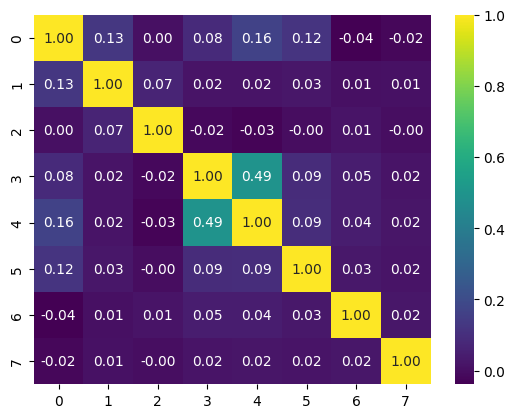

In [93]:
#Se muestra una matriz de correlacion para las variables numericas en el dataset

selected_columns = ['lead_time', 'arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights',
              'stays_in_week_nights','adults','children','babies']  # Add your columns here

# Assemble the selected columns into a single vector column
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
df_assembled = assembler.transform(df_hotels_bookings_clean).select("features")
pearson_matrix = Correlation.corr(df_assembled, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')


In [107]:
#Se crea funcion para encontrar valores nulos en el dataframe
def show_null_values(df):
    null_counts = df.select([col(c).isNull().alias(c) for c in df.columns]) \

    count_ones = [null_counts.select([col(c).alias('value')]) \
                  .filter(col('value') == True) \
                  .count() for c in null_counts.columns]
    

    for i, col_name in enumerate(null_counts.columns):
        
        
        prt=print("Column '{}': Count of Nulls = {}".format(col_name, count_ones[i]))
                      
    return prt
    

In [110]:
nulls= show_null_values(hotels_columns_df)
print(nulls)

"""Elcodigo anterior muestra que hay cuatro columnas con valores nulos: children (4),country(488),agent(16340) y 
company (112593).Se decide borrar todos las observaciones donde la variable 'country' es nulo y en el caso de las variables children, 
agent and company se imputaran utilizando 0"""

Column 'hotel': Count of Nulls = 0
Column 'is_canceled': Count of Nulls = 0
Column 'lead_time': Count of Nulls = 0
Column 'arrival_date_year': Count of Nulls = 0
Column 'arrival_date_month': Count of Nulls = 0
Column 'arrival_date_week_number': Count of Nulls = 0
Column 'arrival_date_day_of_month': Count of Nulls = 0
Column 'stays_in_weekend_nights': Count of Nulls = 0
Column 'stays_in_week_nights': Count of Nulls = 0
Column 'adults': Count of Nulls = 0
Column 'children': Count of Nulls = 4
Column 'babies': Count of Nulls = 0
Column 'meal': Count of Nulls = 0
Column 'country': Count of Nulls = 488
Column 'market_segment': Count of Nulls = 0
Column 'distribution_channel': Count of Nulls = 0
Column 'is_repeated_guest': Count of Nulls = 0
Column 'previous_cancellations': Count of Nulls = 0
Column 'previous_bookings_not_canceled': Count of Nulls = 0
Column 'reserved_room_type': Count of Nulls = 0
Column 'assigned_room_type': Count of Nulls = 0
Column 'booking_changes': Count of Nulls = 0
C

"Elcodigo anterior muestra que hay cuatro columnas con valores nulos: children (4),country(488),agent(16340) y \ncompany (112593).Se decide borrar todos las observaciones donde la variable 'country' es nulo y en el caso de las variables children, \nagent and company se imputaran utilizando 0"

In [111]:
#Se eliminan las observaciones donde el pais es nulo
df_without_country_nulls = hotels_columns_df.na.drop(subset=['country'])

#Se inputan como 0 el resto de valores nulos
df_hotels_imputed = df_without_country_nulls.na.fill(0)

In [114]:
no_nulls= show_null_values(df_hotels_imputed)
print(no_nulls)

"""Puede notarse que no quedan valores nulos en el dataframe"""

Column 'hotel': Count of Nulls = 0
Column 'is_canceled': Count of Nulls = 0
Column 'lead_time': Count of Nulls = 0
Column 'arrival_date_year': Count of Nulls = 0
Column 'arrival_date_month': Count of Nulls = 0
Column 'arrival_date_week_number': Count of Nulls = 0
Column 'arrival_date_day_of_month': Count of Nulls = 0
Column 'stays_in_weekend_nights': Count of Nulls = 0
Column 'stays_in_week_nights': Count of Nulls = 0
Column 'adults': Count of Nulls = 0
Column 'children': Count of Nulls = 0
Column 'babies': Count of Nulls = 0
Column 'meal': Count of Nulls = 0
Column 'country': Count of Nulls = 0
Column 'market_segment': Count of Nulls = 0
Column 'distribution_channel': Count of Nulls = 0
Column 'is_repeated_guest': Count of Nulls = 0
Column 'previous_cancellations': Count of Nulls = 0
Column 'previous_bookings_not_canceled': Count of Nulls = 0
Column 'reserved_room_type': Count of Nulls = 0
Column 'assigned_room_type': Count of Nulls = 0
Column 'booking_changes': Count of Nulls = 0
Col

'Puede notarse que no quedan valores nulos en el dataframe'

In [115]:
#Se muestra el tipo de dato de cada variable resultante
df_hotels_imputed.dtypes


[('hotel', 'string'),
 ('is_canceled', 'string'),
 ('lead_time', 'int'),
 ('arrival_date_year', 'string'),
 ('arrival_date_month', 'string'),
 ('arrival_date_week_number', 'int'),
 ('arrival_date_day_of_month', 'int'),
 ('stays_in_weekend_nights', 'int'),
 ('stays_in_week_nights', 'int'),
 ('adults', 'int'),
 ('children', 'float'),
 ('babies', 'float'),
 ('meal', 'string'),
 ('country', 'string'),
 ('market_segment', 'string'),
 ('distribution_channel', 'string'),
 ('is_repeated_guest', 'string'),
 ('previous_cancellations', 'int'),
 ('previous_bookings_not_canceled', 'int'),
 ('reserved_room_type', 'string'),
 ('assigned_room_type', 'string'),
 ('booking_changes', 'int'),
 ('deposit_type', 'string'),
 ('agent', 'float'),
 ('company', 'float'),
 ('days_in_waiting_list', 'int'),
 ('customer_type', 'string'),
 ('adr', 'float'),
 ('required_car_parking_spaces', 'int'),
 ('total_of_special_requests', 'int'),
 ('reservation_status', 'string')]

In [118]:
#Se hace el 'One Hot Encoding' para las variables categoricas del dataset

categorical_col = ["is_canceled","arrival_date_year","arrival_date_month","meal","country","market_segment","distribution_channel",
                  "reserved_room_type","assigned_room_type","deposit_type","customer_type","reservation_status",
                   "is_repeated_guest"]

indexers = [StringIndexer(inputCol=col, outputCol="{0}_index".format(col)) for col in categorical_col]


encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_vec".format(indexer.getOutputCol())) for indexer in indexers]


pipeline = Pipeline(stages=indexers+encoders)


model = pipeline.fit(df_hotels_bookings_clean)


transformed_df = model.transform(df_hotels_bookings_clean)

#Se transforma la variable objetivo 'hotel' en 1s y 0s
indexer_label = StringIndexer(inputCol='hotel',outputCol='label')
df_label = indexer_label.fit(transformed_df).transform(transformed_df)

#Se muestra la nueva estructura de los datos
df_label.dtypes


[('hotel', 'string'),
 ('is_canceled', 'string'),
 ('lead_time', 'int'),
 ('arrival_date_year', 'string'),
 ('arrival_date_month', 'string'),
 ('arrival_date_week_number', 'int'),
 ('arrival_date_day_of_month', 'int'),
 ('stays_in_weekend_nights', 'int'),
 ('stays_in_week_nights', 'int'),
 ('adults', 'int'),
 ('children', 'float'),
 ('babies', 'float'),
 ('meal', 'string'),
 ('country', 'string'),
 ('market_segment', 'string'),
 ('distribution_channel', 'string'),
 ('is_repeated_guest', 'string'),
 ('previous_cancellations', 'int'),
 ('previous_bookings_not_canceled', 'int'),
 ('reserved_room_type', 'string'),
 ('assigned_room_type', 'string'),
 ('booking_changes', 'int'),
 ('deposit_type', 'string'),
 ('agent', 'float'),
 ('company', 'float'),
 ('days_in_waiting_list', 'int'),
 ('customer_type', 'string'),
 ('adr', 'float'),
 ('required_car_parking_spaces', 'int'),
 ('total_of_special_requests', 'int'),
 ('reservation_status', 'string'),
 ('is_canceled_index', 'double'),
 ('arrival_da

In [119]:
#Se crea el vector de features
assembler = VectorAssembler(
    inputCols=['lead_time', 'arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights',
              'stays_in_week_nights','adults','children','babies',"is_canceled_index_vec","arrival_date_year_index_vec",
              "arrival_date_month_index_vec","meal_index_vec","country_index_vec","market_segment_index_vec",
               "distribution_channel_index_vec","reserved_room_type_index_vec","assigned_room_type_index_vec",
               "deposit_type_index_vec","customer_type_index_vec","reservation_status_index_vec","is_repeated_guest_index_vec"]
    ,outputCol='features',handleInvalid='keep')

vector_df = assembler.transform(df_label)
vector_df = vector_df.select(['features','label'])
vector_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(241,[0,1,2,5,8,1...|  1.0|
|(241,[0,1,2,5,8,1...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[1,2,4,5,8,1...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,1...|  1.0|
|(241,[0,1,2,4,5,1...|  1.0|
|(241,[0,1,2,4,5,1...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,6...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[1,2,4,5,8,1...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [120]:
# Se aplica estandarizacion a las variables predictorias
standard_scaler = StandardScaler(inputCol='features', outputCol='columns_scaled')
scale_model = standard_scaler.fit(vector_df)

scaled_df = scale_model.transform(vector_df)

#Se muestran los resultados
scaled_df.show()

+--------------------+-----+--------------------+
|            features|label|      columns_scaled|
+--------------------+-----+--------------------+
|(241,[0,1,2,5,8,1...|  1.0|(241,[0,1,2,5,8,1...|
|(241,[0,1,2,5,8,1...|  1.0|(241,[0,1,2,5,8,1...|
|(241,[0,1,2,4,5,8...|  1.0|(241,[0,1,2,4,5,8...|
|(241,[0,1,2,4,5,8...|  1.0|(241,[0,1,2,4,5,8...|
|(241,[0,1,2,4,5,8...|  1.0|(241,[0,1,2,4,5,8...|
|(241,[0,1,2,4,5,8...|  1.0|(241,[0,1,2,4,5,8...|
|(241,[1,2,4,5,8,1...|  1.0|(241,[1,2,4,5,8,1...|
|(241,[0,1,2,4,5,8...|  1.0|(241,[0,1,2,4,5,8...|
|(241,[0,1,2,4,5,1...|  1.0|(241,[0,1,2,4,5,1...|
|(241,[0,1,2,4,5,1...|  1.0|(241,[0,1,2,4,5,1...|
|(241,[0,1,2,4,5,1...|  1.0|(241,[0,1,2,4,5,1...|
|(241,[0,1,2,4,5,8...|  1.0|(241,[0,1,2,4,5,8...|
|(241,[0,1,2,4,5,8...|  1.0|(241,[0,1,2,4,5,8...|
|(241,[0,1,2,4,5,6...|  1.0|(241,[0,1,2,4,5,6...|
|(241,[0,1,2,4,5,8...|  1.0|(241,[0,1,2,4,5,8...|
|(241,[0,1,2,4,5,8...|  1.0|(241,[0,1,2,4,5,8...|
|(241,[0,1,2,4,5,8...|  1.0|(241,[0,1,2,4,5,8...|


In [123]:
#Tranformar el vector en columnas para guardar como dataframe en la base de datos
hotels_df_clean=scaled_df.withColumn("columns_scaled", vector_to_array("columns_scaled")).select(["label"] + [col("columns_scaled")[i] for i in range(241)])

#Se verifican las dimensiones del dataframe
print('filas: ', hotels_df_clean.count())
print('columnas: ', len(hotels_df_clean.columns))

filas:  118902
columnas:  242


In [124]:
#Guardar el dataset a la base de datos
hotels_df_clean \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "Tarea3") \
    .save()

In [125]:
#Leer de la base de datos
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "Tarea3") \
    .load()

df.show()

+-----+-------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------

In [126]:
#Volver a convertir el dataframe en columna de vectores para entrenar modelos
feature_columns = [col for col in df.columns if col !='label']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
vector_df = assembler.transform(df)
vector_df = vector_df.select(['features','label'])
vector_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(241,[0,1,2,5,8,1...|  1.0|
|(241,[0,1,2,5,8,1...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[1,2,4,5,8,1...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,1...|  1.0|
|(241,[0,1,2,4,5,1...|  1.0|
|(241,[0,1,2,4,5,1...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,6...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
|(241,[0,1,2,4,5,8...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [127]:
#Primer modelo (Regresion Logistica)

# Division en entrenamiento y prueba
train_data, test_data = vector_df.randomSplit([0.7, 0.3], seed=123)

lr = LogisticRegression(featuresCol="features", labelCol="label")

#Parametros para validacion cruzada
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

#Validacion cruzada
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

#Entrenamiento del modelo
cv_model = crossval.fit(train_data)

#Prediccion en datos de prueba
prediccion_lr = cv_model.transform(test_data)



In [128]:
#Se muestran los datos de la prediccion
prediccion_lr.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(241,[0,1,2,3,4,5...|  1.0|[-3.6960027447276...|[0.02422131566595...|       1.0|
|(241,[0,1,2,3,4,5...|  0.0|[-2.6667051858271...|[0.06496682919912...|       1.0|
|(241,[0,1,2,3,4,5...|  0.0|[-0.9543866474369...|[0.27800348800897...|       1.0|
|(241,[0,1,2,3,4,5...|  1.0|[-5.4512930109495...|[0.00427242120705...|       1.0|
|(241,[0,1,2,3,4,5...|  1.0|[-1.7669045506221...|[0.14592770080142...|       1.0|
|(241,[0,1,2,3,4,5...|  1.0|[-3.0150554432164...|[0.04675033422490...|       1.0|
|(241,[0,1,2,3,4,5...|  1.0|[-0.6854964428328...|[0.33503565964441...|       1.0|
|(241,[0,1,2,3,4,5...|  1.0|[-3.5578776364127...|[0.02770954518187...|       1.0|
|(241,[0,1,2,3,4,5...|  1.0|[-0.2506271189701...|[0.43766914978518...|       1.0|
|(241,[0,1,2,3,4

In [129]:
# Evaluacion del primer modelo curva ROC
evaluator = BinaryClassificationEvaluator(labelCol='label')
roc_lr = evaluator.evaluate(prediccion_lr)
print(f"Area bajo la curva ROC: {roc_lr}")

Area bajo la curva ROC: 0.8796280609020212


In [131]:
#Transformar los datos del primer modelo para escribir a la base de datos
modelo_1=prediccion_lr.withColumn("features", vector_to_array("features")).select(["label","prediction"] + [col("features")[i] for i in range(241)])

#Se muestran las dimensiones
print('Filas: ' ,modelo_1.count())
print('Columnas: ' ,len(modelo_1.columns))

Filas:  35674
Columnas:  243


In [132]:
#Guardar modelo_1 en la base de datos
modelo_1 \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1") \
    .save()

In [133]:
# Segundo Modelo (arbol de decision)

# Division en entrenamiento y prueba
train_data, test_data = vector_df.randomSplit([0.7, 0.3], seed=123)


dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

#Parametros para validacion cruzada
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10]) \
    .addGrid(dt.maxBins, [20, 30]) \
    .build()



#Validacion cruzada
cv = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

#Entrenamiento del modelo
cvModel = cv.fit(train_data)

#Prediccion en datos de prueba
prediccion_dt = cvModel.transform(test_data)



In [134]:
prediccion_dt.show()

+--------------------+-----+--------------+--------------------+----------+
|            features|label| rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+----------+
|(241,[0,1,2,3,4,5...|  1.0|[392.0,1931.0]|[0.16874730951356...|       1.0|
|(241,[0,1,2,3,4,5...|  0.0|[822.0,2202.0]|[0.27182539682539...|       1.0|
|(241,[0,1,2,3,4,5...|  0.0|[392.0,1931.0]|[0.16874730951356...|       1.0|
|(241,[0,1,2,3,4,5...|  1.0|[243.0,1327.0]|[0.15477707006369...|       1.0|
|(241,[0,1,2,3,4,5...|  1.0|   [12.0,11.0]|[0.52173913043478...|       0.0|
|(241,[0,1,2,3,4,5...|  1.0|[392.0,1931.0]|[0.16874730951356...|       1.0|
|(241,[0,1,2,3,4,5...|  1.0|     [5.0,0.0]|           [1.0,0.0]|       0.0|
|(241,[0,1,2,3,4,5...|  1.0|  [95.0,309.0]|[0.23514851485148...|       1.0|
|(241,[0,1,2,3,4,5...|  1.0|[243.0,1327.0]|[0.15477707006369...|       1.0|
|(241,[0,1,2,3,4,5...|  0.0|   [56.0,10.0]|[0.84848484848484...|       0.0|
|(241,[0,1,2

In [135]:
# # Evaluacion del segundo modelo curva ROC
evaluator = BinaryClassificationEvaluator(labelCol='label')
roc_dt = evaluator.evaluate(prediccion_dt)
print(f"Area bajo la curva ROC: {roc_dt}")

Area bajo la curva ROC: 0.623795902419058


In [136]:
#Transformar los datos del segundo modelo para escribir a la base de datos
modelo_2=prediccion_dt.withColumn("features", vector_to_array("features")).select(["label","prediction"] + [col("features")[i] for i in range(241)])

#Se verifican las dimensiones del dataframe
print('Filas: ', modelo_2.count())
print('Columnas: ',len(modelo_2.columns))

Filas:  35674
Columnas:  243


In [137]:
#Guardar modelo_2 en la base de datos
modelo_2 \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo2") \
    .save()

In [151]:
#Comparacion de resultados
print(f'Area bajo la curva ROC para el modelo de Regresion Logistica: {roc_lr} \n'
      f'Area bajo la curva ROC para el modelo de Arbol de Decision: {roc_dt}')

'''Como puede observarse el area bajo la curva ROC (AUC) es mas alta para el modelo de regresion logistica que para
el arbol de decision lo cual implica que este modelo hace un mejor trabajo discriminando entre positivos verdaderos y 
falsos positivos para cada umbral de decision. Por tanto el modelo de regresion logistica es mejor'''

Area bajo la curva ROC para el modelo de Regresion Logistica: 0.8796280609020212 
Area bajo la curva ROC para el modelo de Arbol de Decision: 0.623795902419058


'Como puede observarse el area bajo la curva ROC (AUC) es mas alta para el modelo de regresion logistica que para\nel arbol de decision lo cual implica que este modelo hace un mejor trabajo discriminando entre positivos verdaderos y \nfalsos positivos para cada umbral de decision. Por tanto el modelo de regresion logistica es mejor'